In [1]:
from pymongo import MongoClient
from pprint import pprint
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import itertools
import time
import re

In [2]:
%%time
client = MongoClient('mongodb://localhost:27017')
db = client.spire
status = db.command('serverStatus')
runs = db.runs

not_picks_agg = [
    {
        '$match': {
            'event.character_chosen': 'IRONCLAD', 
            'event.floor_reached': {
                '$gte': 40
            }, 
            'event.ascension_level': {
                '$gte': 15
            }
        }
    }, {
        '$project': {
            'event.card_choices': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices'
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices.not_picked'
        }
    }, {
        '$project': {
            'event.card_choices.not_picked': 1, 
            'event.card_choices.floor': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$group': {
            '_id': {
                'not_picked': '$event.card_choices.not_picked', 
                'floor': '$event.card_choices.floor'
            }, 
            'count': {
                '$sum': 1
            }, 
            'card': {
                '$first': '$event.card_choices.not_picked'
            }, 
            'floor': {
                '$first': '$event.card_choices.floor'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]
not_picks_result = runs.aggregate(not_picks_agg)
tmp = pd.DataFrame(list(not_picks_result))
tmp

CPU times: user 145 ms, sys: 5.72 ms, total: 150 ms
Wall time: 6.75 s


,_id,count,card,floor
0,"{'not_picked': 'Brutality', 'floor': 16}",1719,Brutality,16.0
1,"{'not_picked': 'Exhume', 'floor': 16.0}",1683,Exhume,16.0
2,"{'not_picked': 'Bludgeon', 'floor': 16.0}",1632,Bludgeon,16.0
3,"{'not_picked': 'Berserk', 'floor': 16}",1610,Berserk,16.0
4,"{'not_picked': 'Juggernaut', 'floor': 16}",1576,Juggernaut,16.0
...,...,...,...,...
10105,"{'not_picked': 'Double Tap+1', 'floor': 37.0}",1,Double Tap+1,37.0
10106,"{'not_picked': 'Hologram', 'floor': 19.0}",1,Hologram,19.0
10107,"{'not_picked': 'Tactician', 'floor': 21.0}",1,Tactician,21.0
10108,"{'not_picked': 'Self Repair', 'floor': 27.0}",1,Self Repair,27.0


In [3]:
commons = [
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
]
uncommons = [
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    # missing items
    'Entrench',
    # missing items
]
rares = [
    'Demon Form',
    'Juggernaut',
    'Offering',
    'Feed',
    'Corruption',
    'Berserk',
    'Reaper',
    'Bludgeon',
    'Limit Break',
    'Double Tap',
    'Exhume',
    'Immolate',
    'Fiend Fire',
    'Barricade',
    'Brutality',
    'Impervious',
]

In [4]:
not_picks_df = tmp.pivot(index='card', columns='floor')['count']
not_picks_df.loc['Bludgeon'][:30]

floor
0.0       46.0
1.0        NaN
2.0        3.0
3.0        5.0
4.0        9.0
5.0       15.0
6.0       48.0
7.0       55.0
8.0       40.0
9.0        NaN
10.0      52.0
11.0      32.0
12.0      51.0
13.0      44.0
14.0      59.0
15.0       1.0
16.0    1632.0
17.0       NaN
18.0       2.0
19.0       5.0
20.0       9.0
21.0      12.0
22.0      25.0
23.0      55.0
24.0      52.0
25.0      45.0
26.0       NaN
27.0      54.0
28.0      52.0
29.0      50.0
30.0      62.0
Name: Bludgeon, dtype: float64

In [5]:
%%time
picks_agg = [
    {
        '$match': {
            'event.character_chosen': 'IRONCLAD', 
            'event.floor_reached': {
                '$gte': 30
            }, 
            'event.ascension_level': {
                '$gte': 5
            }
        }
    }, {
        '$project': {
            'event.card_choices': 1, 
            'event.ascension_level': 1
        }
    }, {
        '$unwind': {
            'path': '$event.card_choices'
        }
    # }, {
    #     '$match': {
    #         'event.card_choices.picked': {
    #             '$ne': 'SKIP'
    #         }
    #     }
    }, {
        '$group': {
            '_id': {
                'picked': '$event.card_choices.picked', 
                'floor': '$event.card_choices.floor'
            }, 
            'count': {
                '$sum': 1
            }, 
            'card': {
                '$first': '$event.card_choices.picked'
            }, 
            'floor': {
                '$first': '$event.card_choices.floor'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]
picks_result = runs.aggregate(picks_agg)
tmp = pd.DataFrame(list(picks_result))
tmp

CPU times: user 96.1 ms, sys: 2.11 ms, total: 98.2 ms
Wall time: 23.2 s


,_id,count,card,floor
0,"{'picked': 'SKIP', 'floor': 18}",17674,SKIP,18.0
1,"{'picked': 'SKIP', 'floor': 35}",14256,SKIP,35.0
2,"{'picked': 'SKIP', 'floor': 31}",13179,SKIP,31.0
3,"{'picked': 'SKIP', 'floor': 24}",10980,SKIP,24.0
4,"{'picked': 'SKIP', 'floor': 14}",10205,SKIP,14.0
...,...,...,...,...
10287,"{'picked': 'Metallicize+1', 'floor': 4.0}",1,Metallicize+1,4.0
10288,"{'picked': 'Predator', 'floor': 10}",1,Predator,10.0
10289,"{'picked': 'Redo+1', 'floor': 46}",1,Redo+1,46.0
10290,"{'picked': 'Combust+1', 'floor': 4}",1,Combust+1,4.0


In [6]:
picks_df = tmp.pivot(index='card', columns='floor')['count']
picks_df.loc['Bludgeon'][16]

1350.0

In [7]:
not_picks_df.loc['Bludgeon'][16]

1632.0

In [8]:
offered_df = picks_df + not_picks_df

In [9]:
offered_df.loc['Bludgeon'][16]

2982.0

In [10]:
pickrate_df = picks_df / offered_df
print('offered')
print(offered_df.loc[['Bludgeon', 'Limit Break', 'Offering']].iloc[: , 20:30])
print('pickrate')
print(pickrate_df.loc[['Bludgeon', 'Limit Break', 'Offering']].iloc[: , 20:30])


offered
floor        20.0  21.0  22.0   23.0   24.0   25.0  26.0   27.0   28.0   29.0
card                                                                         
Bludgeon     23.0  34.0  48.0  112.0  122.0   98.0   NaN  105.0   99.0  101.0
Limit Break  41.0  53.0  69.0  200.0  205.0  180.0   NaN  165.0  150.0  180.0
Offering     57.0  50.0  98.0  225.0  217.0  171.0   NaN  166.0  151.0  180.0
pickrate
floor            20.0      21.0      22.0      23.0      24.0      25.0  26.0  \
card                                                                            
Bludgeon     0.608696  0.647059  0.479167  0.508929  0.573770  0.540816   NaN   
Limit Break  0.780488  0.886792  0.811594  0.840000  0.892683  0.800000   NaN   
Offering     0.929825  0.920000  0.948980  0.866667  0.889401  0.923977   NaN   

floor            27.0      28.0      29.0  
card                                       
Bludgeon     0.485714  0.474747  0.504950  
Limit Break  0.848485  0.833333  0.850000  
Offering   

AxesSubplot(0.125,0.125;0.775x0.755)


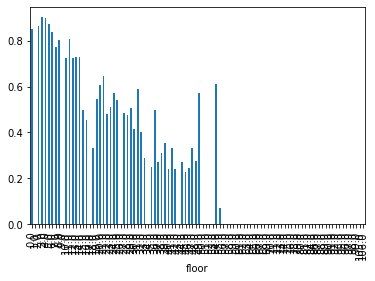

In [11]:
import matplotlib.pyplot as plt
print(pickrate_df.loc['Bludgeon'].T.plot(kind="bar"))

[<AxesSubplot:title={'center':'Wild Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Perfected Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Anger'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Iron Wave'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Heavy Blade'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Clothesline'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Flex'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Havoc'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Pommel Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Warcry'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Twin Strike'}, xlabel='floor'>
 <AxesSubplot:title={'center':'True Grit'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Thunderclap'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Sword Boomerang'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Body Slam'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Clash'}, xlabel='floor'>
 <AxesSubplot:title={'center':'Ar

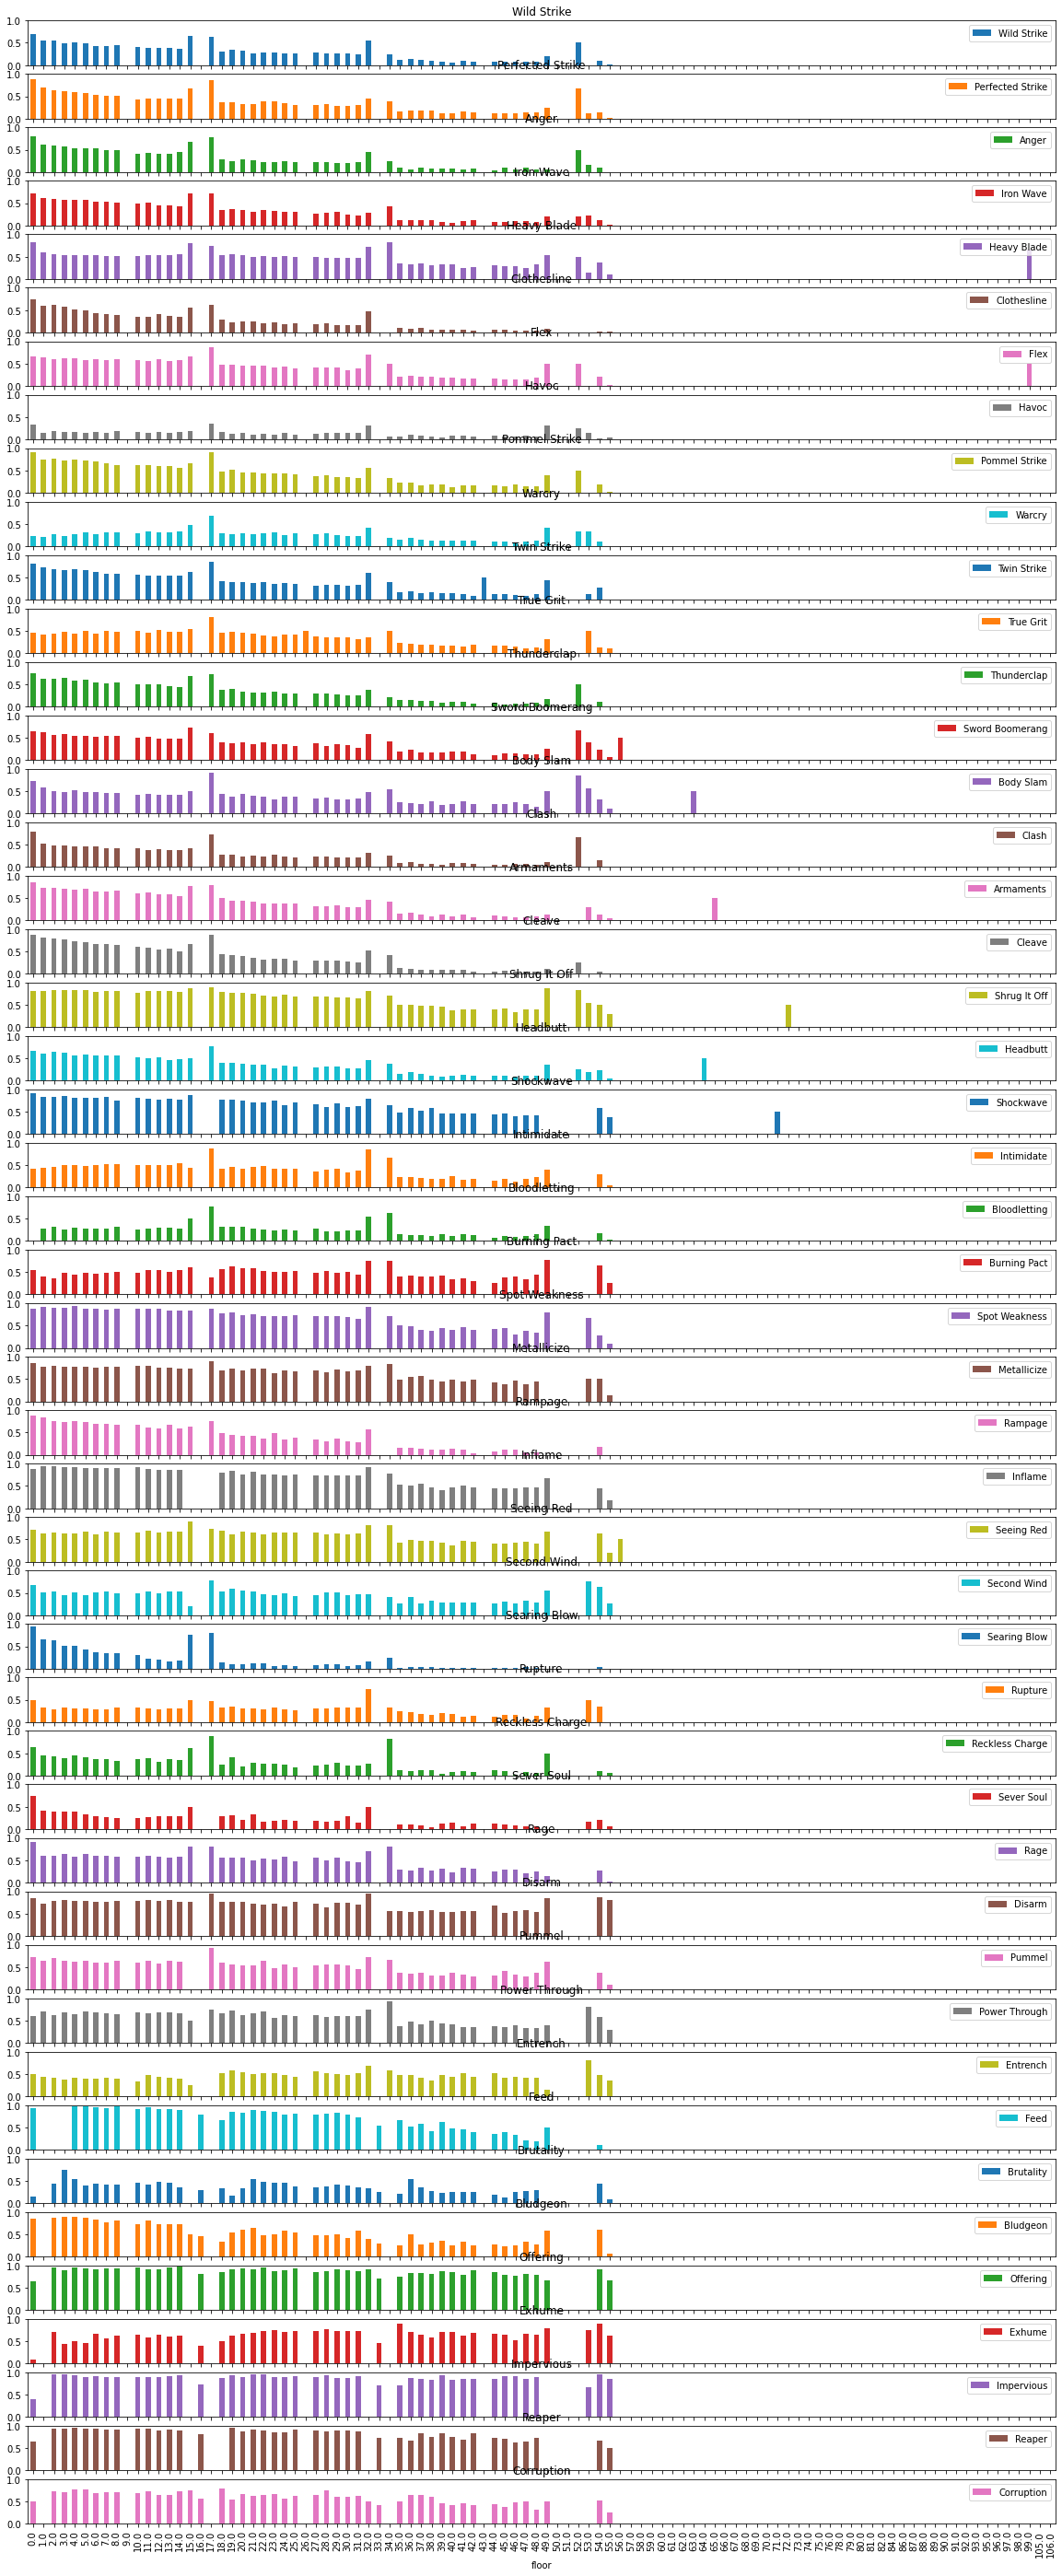

In [12]:
%%time
print(pickrate_df.loc[[
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    
    'Entrench',
    
    'Feed',
    'Brutality',
    'Bludgeon',
    'Offering',
    'Exhume',
    'Impervious',
    'Reaper',
    'Corruption',
]].T.plot(kind="bar", figsize=(20, 50), subplots=True, ylim=(0,1)))

In [13]:
%%time
picks_df.loc['SKIP']

CPU times: user 321 µs, sys: 8 µs, total: 329 µs
Wall time: 335 µs


floor
0.0         NaN
1.0      6151.0
2.0      2695.0
3.0      3261.0
4.0      4148.0
          ...  
97.0        7.0
98.0        6.0
99.0       25.0
105.0       3.0
106.0       1.0
Name: SKIP, Length: 98, dtype: float64

In [14]:
picks_df.sum()

floor
0.0       6123.0
1.0      51575.0
2.0      19121.0
3.0      20814.0
4.0      23258.0
          ...   
97.0         8.0
98.0         6.0
99.0        31.0
105.0        3.0
106.0        1.0
Length: 98, dtype: float64

array([<AxesSubplot:title={'center':'None'}, xlabel='floor'>],
      dtype=object)

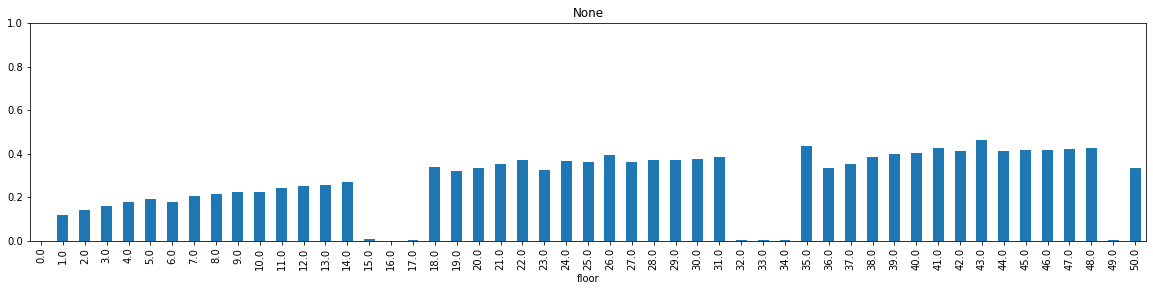

In [15]:
skip_pick_rate = (picks_df.loc['SKIP'] / picks_df.sum())[:50]
skip_pick_rate.plot(kind="bar", figsize=(20, 4), subplots=True, ylim=(0, 1))

CPU times: user 3.75 s, sys: 0 ns, total: 3.75 s
Wall time: 3.79 s


array([<AxesSubplot:title={'center':'Wild Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Perfected Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Anger'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Iron Wave'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Heavy Blade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Clothesline'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Flex'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Havoc'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Pommel Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Warcry'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Twin Strike'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'True Grit'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Thunderclap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sword Boomerang'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Body Slam'}, x

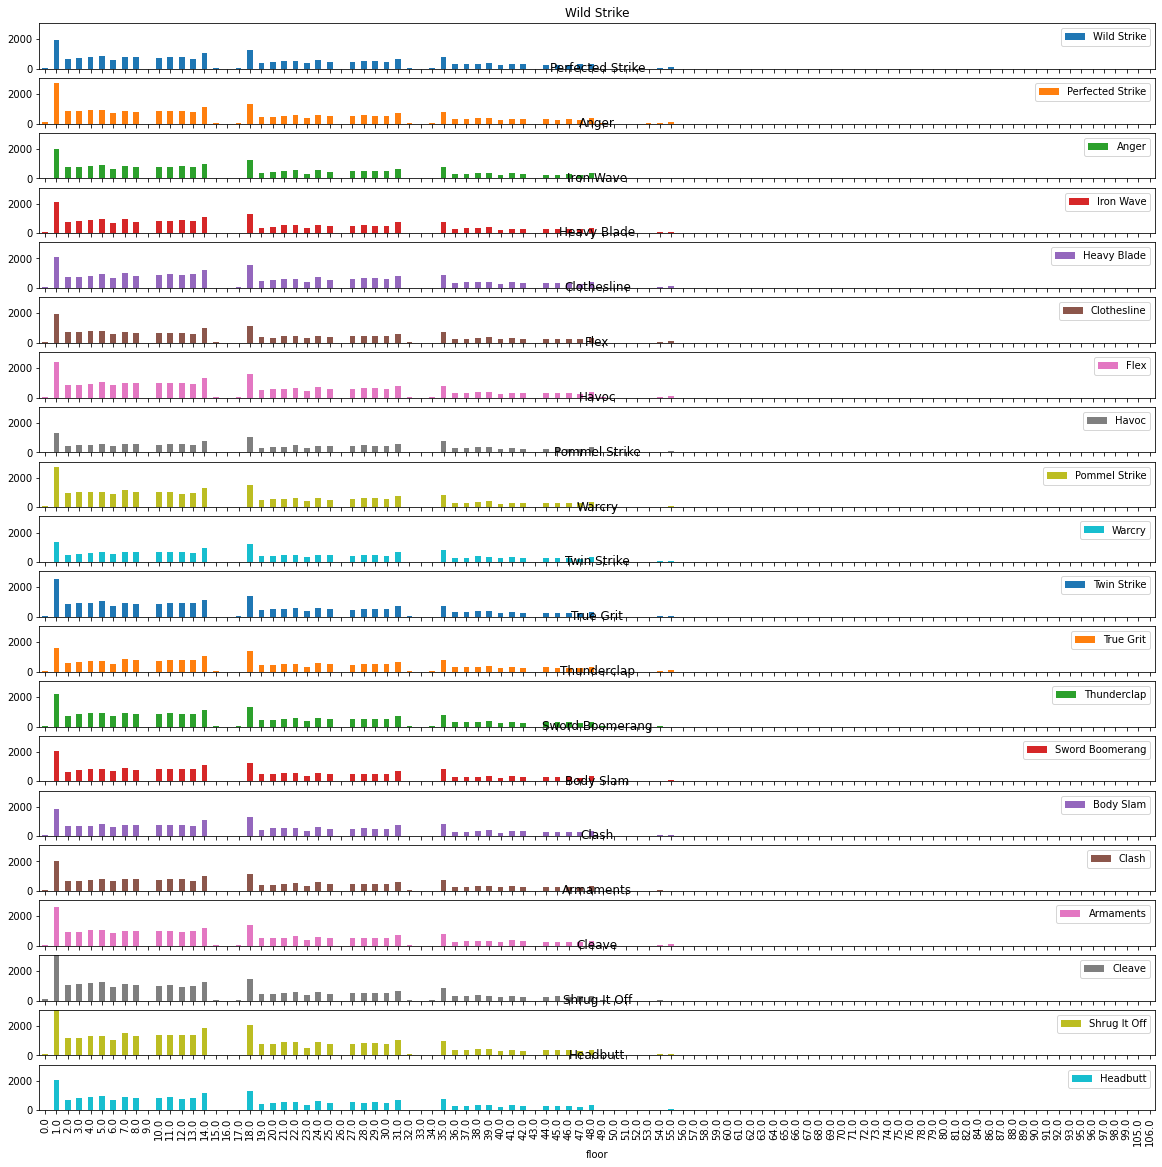

In [16]:
%%time
offered_commons = offered_df.loc[[
    'Wild Strike',
    'Perfected Strike',
    'Anger',
    'Iron Wave',
    'Heavy Blade',
    'Clothesline',
    'Flex',
    'Havoc',
    'Pommel Strike',
    'Warcry',
    'Twin Strike',
    'True Grit',
    'Thunderclap',
    'Sword Boomerang',
    'Body Slam',
    'Clash',
    'Armaments',
    'Cleave',
    'Shrug It Off',
    'Headbutt',
]]
offered_commons.T.plot(kind="bar", figsize=(20, len(offered_commons.index)), subplots=True, ylim=(0, offered_commons.max().max()))

CPU times: user 3.7 s, sys: 27.8 ms, total: 3.73 s
Wall time: 3.79 s


array([<AxesSubplot:title={'center':'Shockwave'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Intimidate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bloodletting'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Burning Pact'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Spot Weakness'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Metallicize'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rampage'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Inflame'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Seeing Red'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Second Wind'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Searing Blow'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rupture'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reckless Charge'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Sever Soul'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Rage'

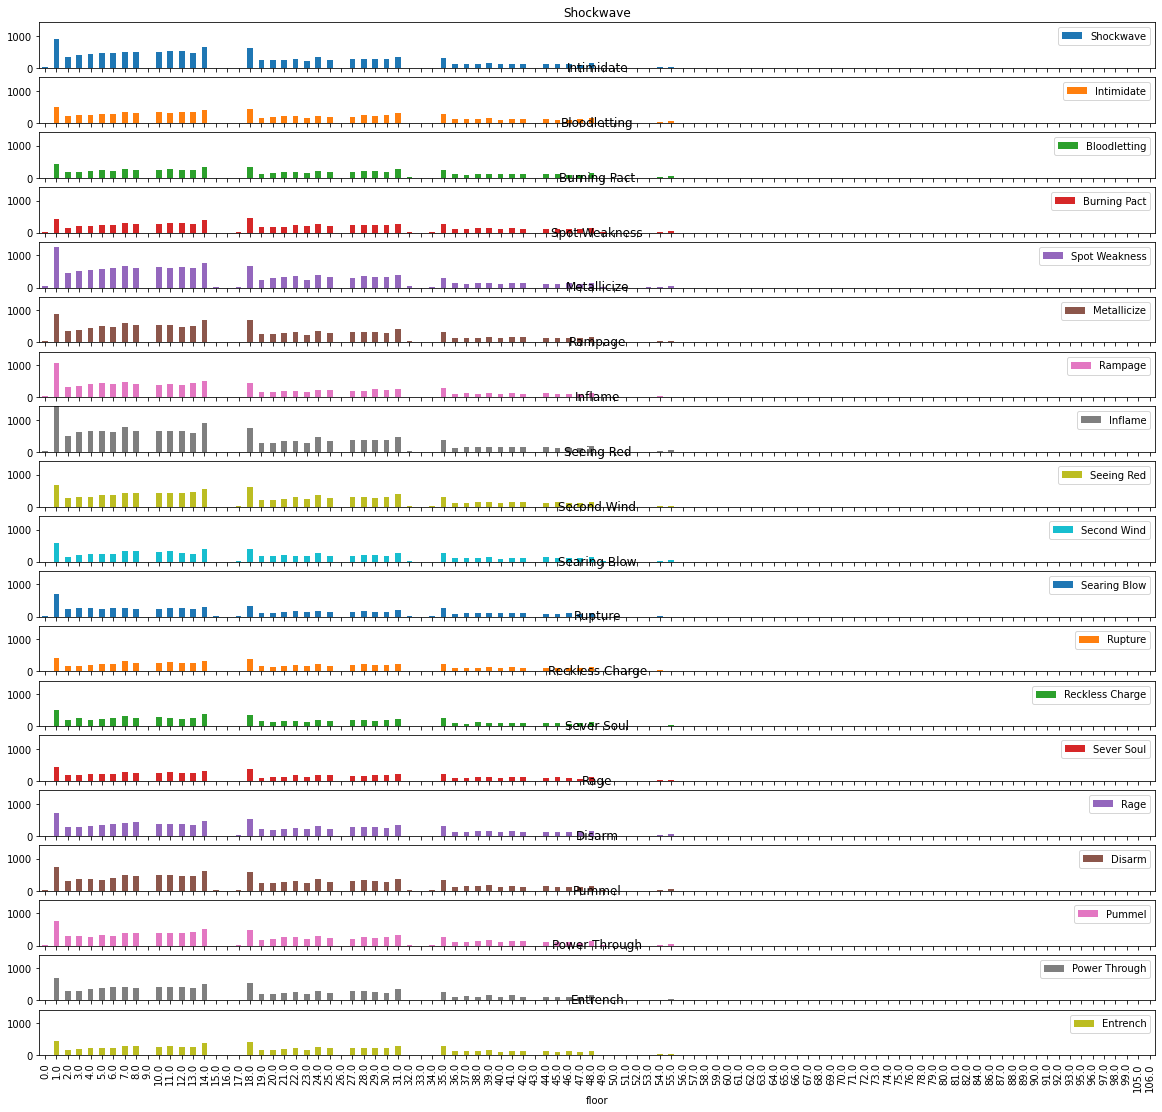

In [17]:
%%time
offered_uncommons = offered_df.loc[[
    'Shockwave',
    'Intimidate',
    'Bloodletting',
    'Burning Pact',
    'Spot Weakness',
    'Metallicize',
    'Rampage',
    'Inflame',
    'Seeing Red',
    'Second Wind',
    'Searing Blow',
    'Rupture',
    'Reckless Charge',
    'Sever Soul',
    'Rage',
    'Disarm',
    'Pummel',
    'Power Through',
    # missing items
    'Entrench',
    # missing items
]]
offered_uncommons.T.plot(kind="bar", figsize=(20, len(offered_uncommons.index)), subplots=True, ylim=(0, offered_uncommons.max().max()))

CPU times: user 3 s, sys: 39.7 ms, total: 3.04 s
Wall time: 3.09 s


array([<AxesSubplot:title={'center':'Demon Form'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Juggernaut'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Offering'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Feed'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Corruption'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Berserk'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reaper'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bludgeon'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Limit Break'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Double Tap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Exhume'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Immolate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Fiend Fire'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Barricade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Brutality'}, xlabel='floor'>,
    

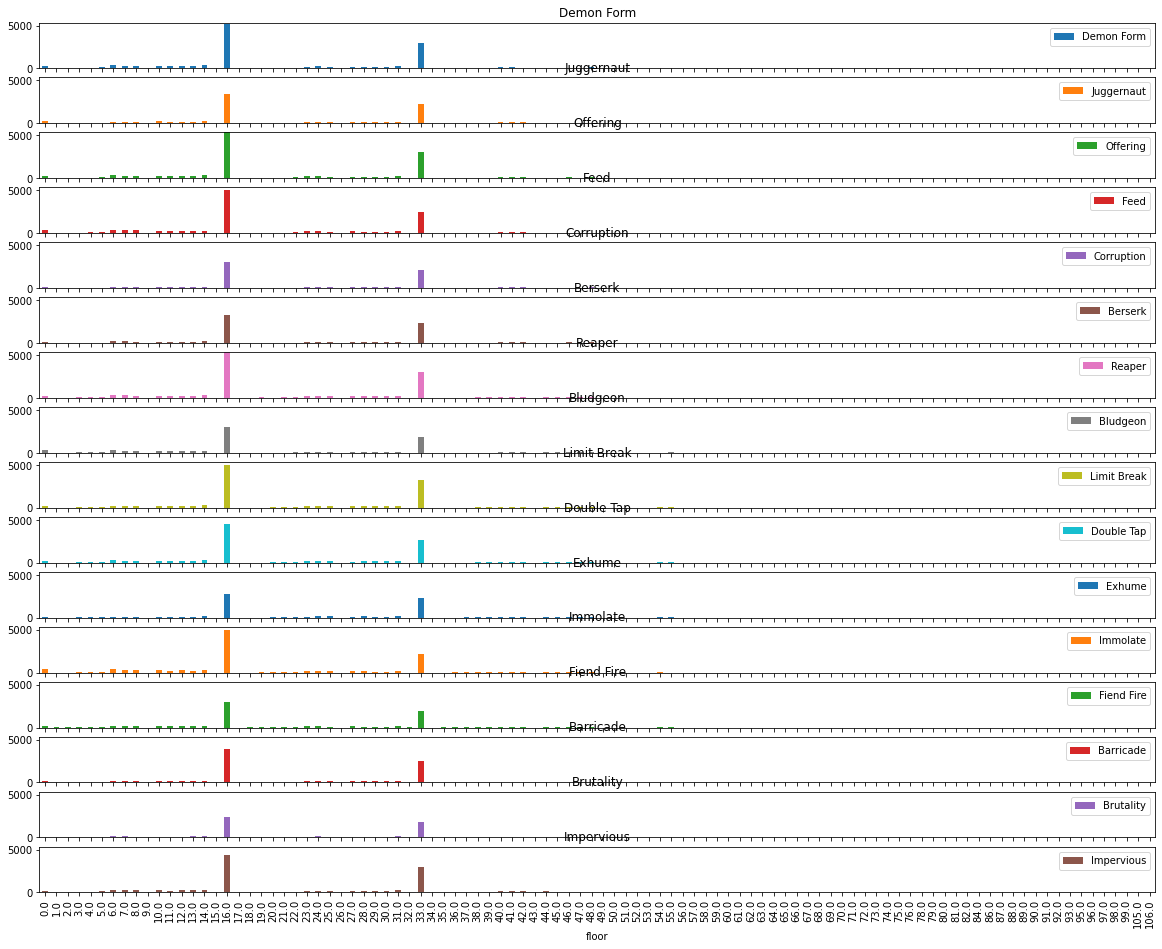

In [18]:
%%time
offered_rares = offered_df.loc[rares]

offered_rares.T.plot(kind="bar", figsize=(20, len(offered_rares.index)), subplots=True, ylim=(0, offered_rares.max().max()))

In [19]:
offers_by_floor = offered_df.sum()
offers_by_floor[:5]

floor
0.0     8565.0
1.0    69994.0
2.0    25358.0
3.0    27529.0
4.0    30288.0
5.0    32448.0
dtype: float64

array([<AxesSubplot:title={'center':'Demon Form'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Juggernaut'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Offering'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Feed'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Corruption'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Berserk'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Reaper'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Bludgeon'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Limit Break'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Double Tap'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Exhume'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Immolate'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Fiend Fire'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Barricade'}, xlabel='floor'>,
       <AxesSubplot:title={'center':'Brutality'}, xlabel='floor'>,
    

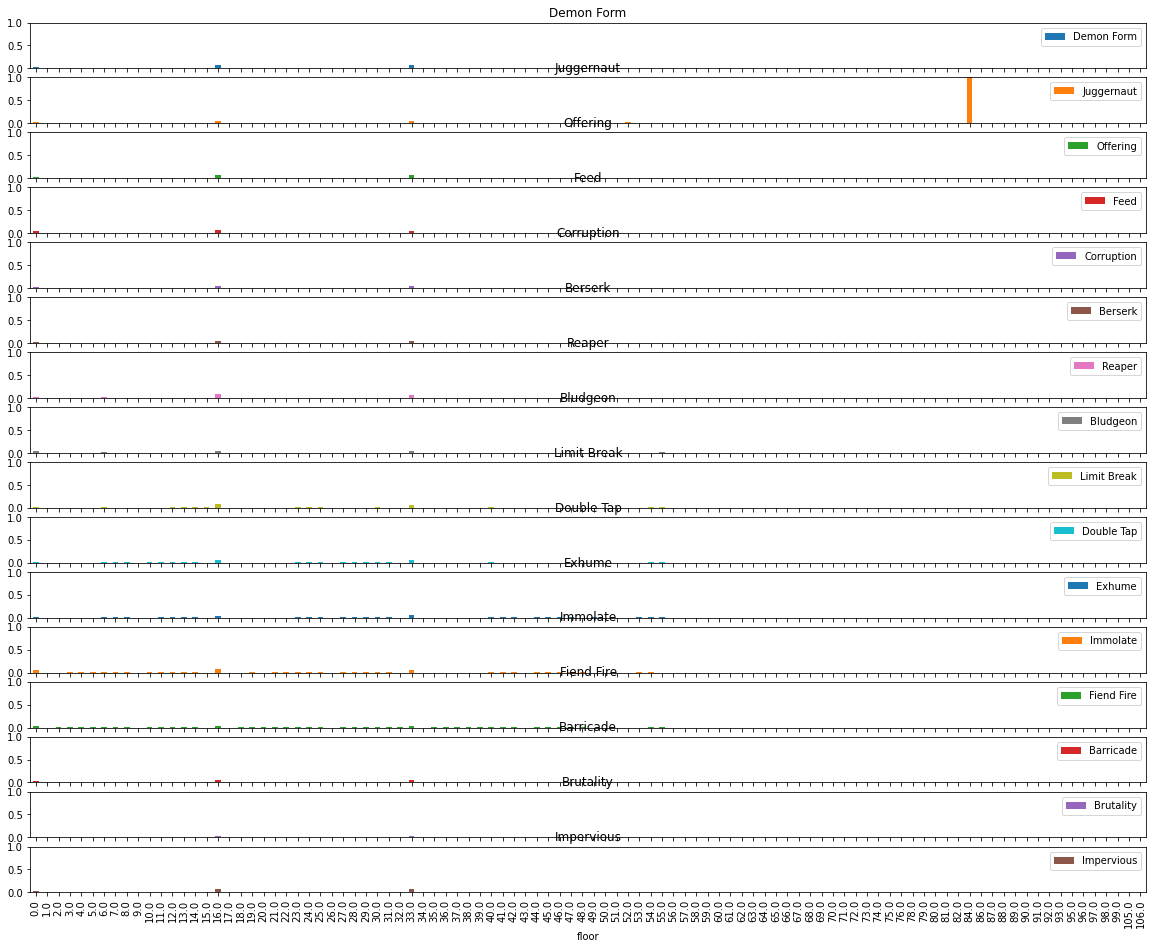

In [20]:
offer_rates = offered_df / offers_by_floor
offer_rates_rares = offer_rates.loc[rares]
offer_rates_rares.T.plot(kind="bar", figsize=(20, len(offer_rates_rares.index)), subplots=True, ylim=(0, offer_rates_rares.max().max()))

In [21]:
a = offered_df.loc['Corruption'][16]
b = offers_by_floor.loc[16]
print(a)
print(b)
print(a / b)
print(offered_df.loc[rares][16].sum())

3072.0
69086.0
0.04446631734360073
64797.0
